In [1]:
import os
import numpy as np
import rasterio
import rasterio.mask
import imageio
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatch
import imageio
from dem_utils_examples import load_rast, th_vals, plot_rast, gdal_process

# TODO: import libraries

C:\Users\montse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


ModuleNotFoundError: No module named 'crop_raster'

## Open raster values from tiff file

In [ ]:
dem_path = 'C:/Users/montse/Desktop/ARI-Git/jupyterlab-data-science/src/kram_files/inputs/dem_saetde.tif'
dem_nodata_path = './notebook_outputs/rasters/dem_saetde_nodata.tif'

In [ ]:
#Remove file in order to rewrite it
del_file = rasterio.open(dem_nodata_path)
del_file.close()# close the rasterio dataset
os.remove(dem_nodata_path); 
  ##Only use it if we already have created the tif image; in the other way we can't rewrite it!

In [ ]:
#Delete the NoDataVals: 
dem_array_nodata = th_vals.raster_threshold_to_nan(dem_path)
load_rast.write_raster_array(dem_array_nodata, dem_path, dem_nodata_path)

#Other way to save file, works better in slope calculation(gdal)
dem_nodata_im_path = './notebook_outputs/rasters/dem_saetde_nodata_imageio.tif'
imageio.imwrite(dem_nodata_im_path, dem_array_nodata)

## Plot the Map using GDAL and matplotlib

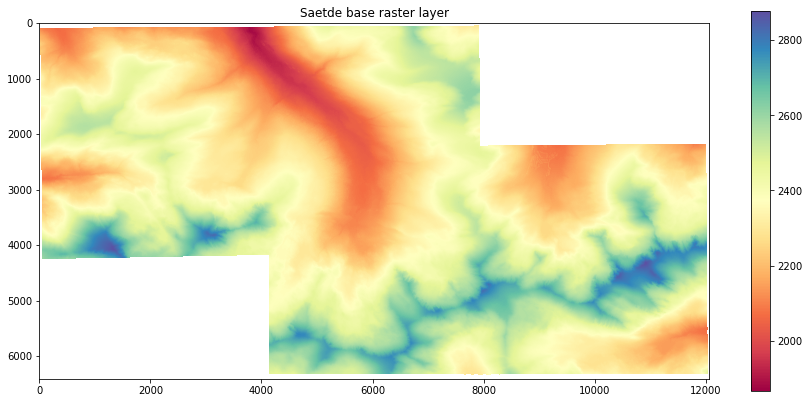

In [ ]:
base_raster_path_img = './notebook_outputs/images/saetde_baselayer.png'
title = 'Saetde base raster layer'
plot_rast.plot_raster(dem_nodata_path, base_raster_path_img, title,  cmap='Spectral')

## Create a Hillshade raster

In [ ]:
hillshade_out_path = './notebook_outputs/rasters/dem_hillshade.tif'
saetde_hillshade = gdal_process.calculate_hillshade_dem(dem_nodata_path, hillshade_out_path)

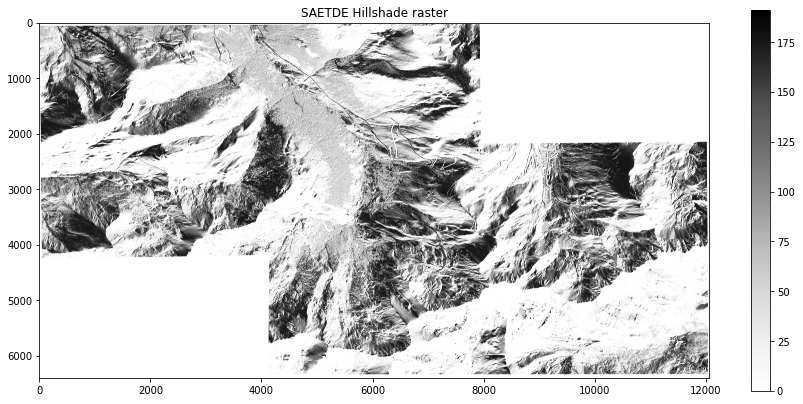

In [ ]:
#Visualize the Hillshade raster
hillshade_img_path = './notebook_outputs/images/saetde_hillshade.png'
plot_rast.plot_raster(hillshade_out_path, hillshade_img_path, 'SAETDE Hillshade raster', cmap='Greys')

## Calculate the Aspect using GDAL

In [ ]:
aspect_out_path = './notebook_outputs/rasters/dem_aspect.tif'
saetde_aspect = gdal_process.calculate_aspect_dem(dem_nodata_path, aspect_out_path)
saetde_aspect = np.where(saetde_aspect==-9999., np.nan, saetde_aspect) #Replace thershold values for 0 => If we do not do it, we will have no contrast from real pizel value variations
load_rast.write_raster_array(saetde_aspect, dem_nodata_path, aspect_out_path)

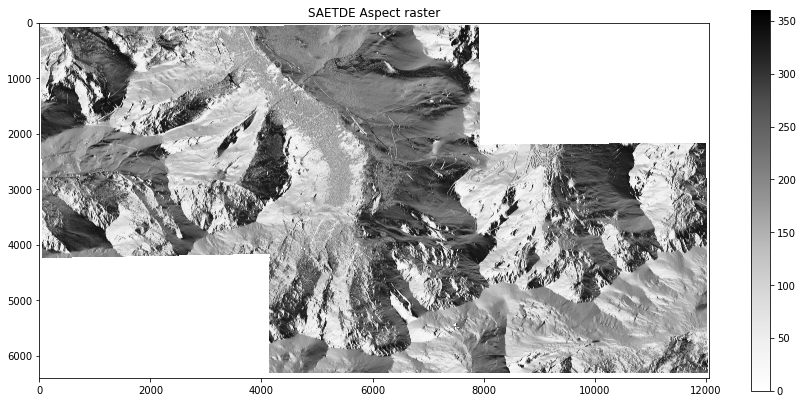

In [ ]:
#Visualize the Aspect raster
aspect_img_path = './notebook_outputs/images/saetde_aspect.png'
plot_rast.plot_raster(aspect_out_path, aspect_img_path, 'SAETDE Aspect raster', cmap='Greys')

Creation of a classified object

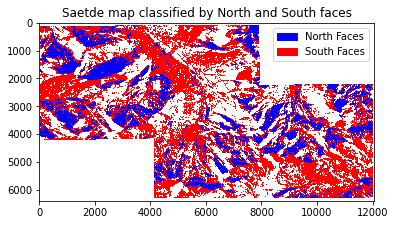

In [ ]:
raster_saet_aspect_class = np.copy(saetde_aspect)
raster_saet_aspect_class[np.where((saetde_aspect>=0) & (saetde_aspect<=45) | (saetde_aspect>=315))] = 1 #Northwest to Northest
raster_saet_aspect_class[np.where((saetde_aspect>=135) & (saetde_aspect<=225))] = 2 #Southeast to Southwest
raster_saet_aspect_class[np.where((saetde_aspect>45) & (saetde_aspect<135) | (saetde_aspect>225) & (saetde_aspect<315))] = 3 #West and East faces

#Visualization:
cmap_colors = colors.ListedColormap(['blue', 'red', 'white'])
plt.Figure(figsize=(15,7))
plt.imshow(raster_saet_aspect_class, cmap=cmap_colors)
plt.title('Saetde map classified by North and South faces')
ax= plt.gca()

north_class = mpatch.Patch(color='blue', label='North Faces')
south_class = mpatch.Patch(color='red', label= 'South Faces')
list_labels = [north_class, south_class]
ax.legend(handles= list_labels)
#plt.savefig('./notebook_outputs/images/saetde_aspect_class.png', dpi=1000)
plt.show()

## Calculate the slope using GDAL

In [ ]:
#We calculate the slope of the base raster
slope_out_path = './notebook_outputs/rasters/dem_slope.tif'
saetde_slope = gdal_process.calculate_slope_dem(dem_nodata_im_path, slope_out_path) 
saet_slope_clean = np.where(saetde_slope==-9999., np.nan, saetde_slope) #noDataVal replacement

#We save the slope raster in the proper format
load_rast.write_raster_rasterio(saet_slope_clean, dem_nodata_path, slope_out_path)

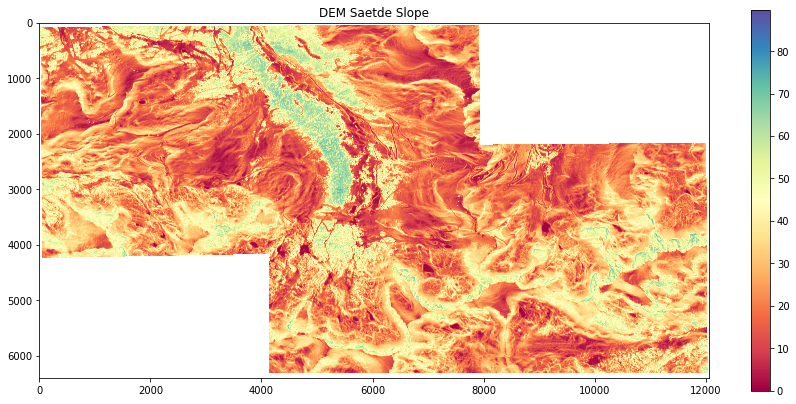

In [ ]:
#We plot the slope raster
slope_img_path = './notebook_outputs/images/saetde_slope'
title_slope = 'DEM Saetde Slope'
plot_rast.plot_raster(slope_out_path, slope_img_path, title_slope, cmap='Spectral')

Histogram Analysis of the slopes

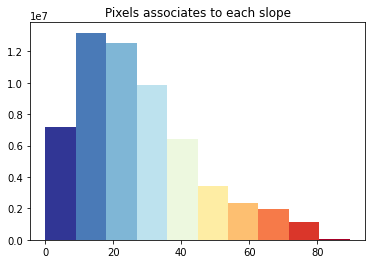

In [ ]:
saet_notnan = saet_slope_clean[~np.isnan(saet_slope_clean)] #We set all the NaN values to 0 in order to correctly plot the percentatges

#Plot Histogram: 
cm = plt.cm.get_cmap('RdYlBu_r')
n, bins, patches = plt.hist(saet_notnan, 10, color= 'Green')
bin_centers = 0.5 * (bins[:-1] + bins[1:])

col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
plt.title('Pixels associates to each slope')
#plt.savefig('./notebook_outputs/images/saetde_slope_hist.png')
plt.show()

Creation of a classified raster (slope) object

In [ ]:
saet_clean = np.nan_to_num(saet_slope_clean) #We set all NaN values to 0
saet_slope_reclass = np.copy(saet_clean) 
saet_slope_reclass[np.where(saet_clean == 0)] = 1
saet_slope_reclass[np.where((saet_clean>0) & (saet_clean<=5))] = 2
saet_slope_reclass[np.where((saet_clean>5) & (saet_clean<=10))] = 3
saet_slope_reclass[np.where((saet_clean>10) & (saet_clean<=15))] = 4
saet_slope_reclass[np.where((saet_clean>15) & (saet_clean<=20))] = 5
saet_slope_reclass[np.where((saet_clean>20) & (saet_clean<=25))] = 6
saet_slope_reclass[np.where((saet_clean>25) & (saet_clean<=30))] = 7
saet_slope_reclass[np.where((saet_clean>30) & (saet_clean<=40))] = 8
saet_slope_reclass[np.where((saet_clean>40) & (saet_clean<=60))] = 9
saet_slope_reclass[np.where((saet_clean>60) & (saet_clean<=90))] = 10

#slope_class_path = './outputs/rasters/slope_classified_raster.tif'
#load_rast.write_raster_array(saet_slope_reclass, slope_path, slope_class_path)

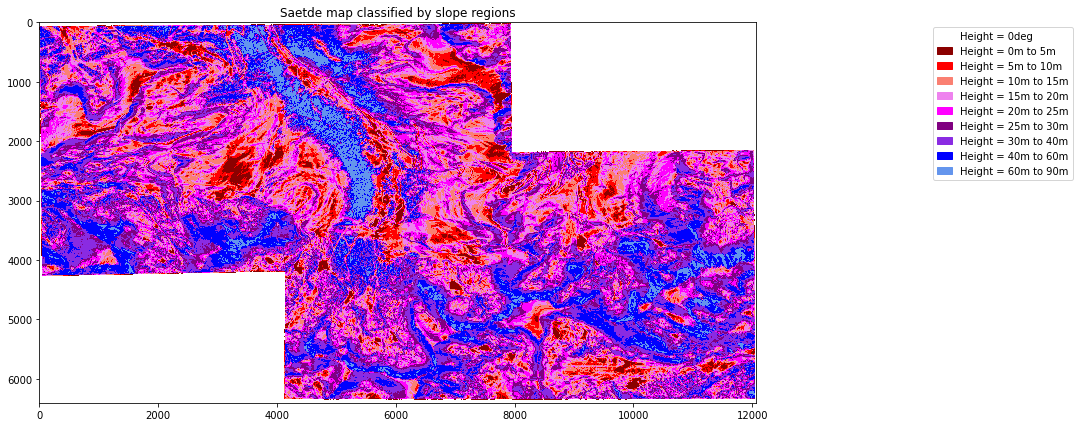

In [ ]:
#Visualize classified raster object
plt.figure(figsize=(15,7))
cmap_colors = colors.ListedColormap(['white', 'darkred', 'red', 'salmon', 'violet', 'magenta', 'purple','blueviolet','blue', 'cornflowerblue'])

plt.imshow(saet_slope_reclass, cmap=cmap_colors)
plt.title('Saetde map classified by slope regions')

class1 = mpatch.Patch(color='white', label= 'Height = 0deg')
class2 = mpatch.Patch(color='darkred', label= 'Height = 0m to 5m')
class3 = mpatch.Patch(color='red', label= 'Height = 5m to 10m')
class4 = mpatch.Patch(color='salmon', label= 'Height = 10m to 15m')
class5 = mpatch.Patch(color='violet', label= 'Height = 15m to 20m')
class6 = mpatch.Patch(color='magenta', label= 'Height = 20m to 25m')
class7 = mpatch.Patch(color='purple', label= 'Height = 25m to 30m')
class8 = mpatch.Patch(color='blueviolet', label= 'Height = 30m to 40m')
class9 = mpatch.Patch(color='blue', label= 'Height = 40m to 60m')
class10 = mpatch.Patch(color='cornflowerblue', label= 'Height = 60m to 90m')
list_class = [class1, class2, class3, class4, class5, class6, class7, class8, class9, class10]
ax = plt.gca()
ax.legend(
  handles= list_class,
  handlelength=1.5, #Size of the color in the legend
  bbox_to_anchor= (1.45, 1) #Position of the legend
)
#plt.savefig('./outputs/images/saetde_slope_class.png', dpi=1000)

In [ ]:
#Basic data extracted from the previous raster
min_val = np.min(saet_notnan); print(min_val)
max_val = np.max(saet_notnan); print(max_val)
mean_val = np.mean(saet_notnan); print(mean_val)

0.0
89.5954
27.287693
